In [1]:
import util.Simulation as Gsim
import util.RotRep as Rot
import numpy as np
import matplotlib.pyplot as plt
from util.config import Config
import os
from util.make_micFile import find_grains
from util.calibration_misc import data_prep, optimize_detector, write_config_file, write_peak_file
import yaml
import h5py
import time


## Make microstructure file


Number of features found using blob finder:  243
-0.556875 -0.360484


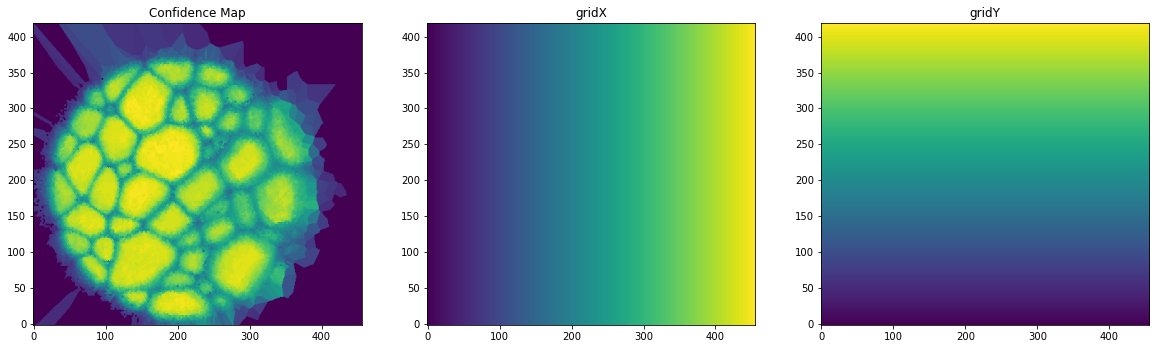

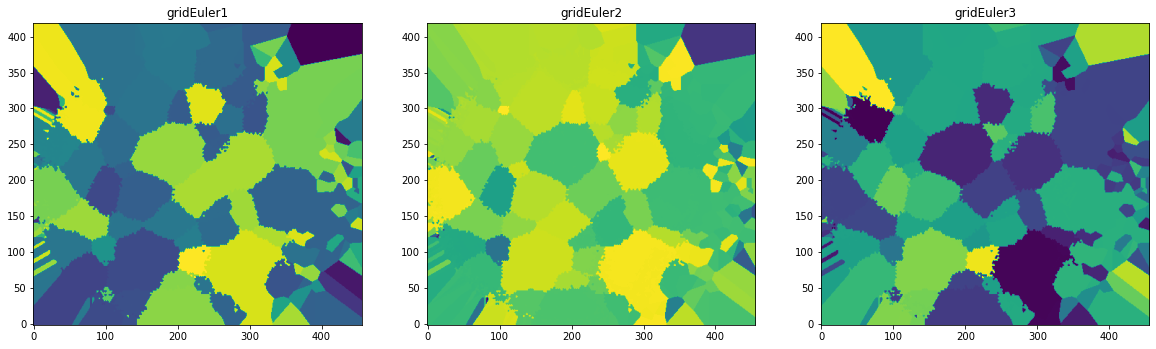

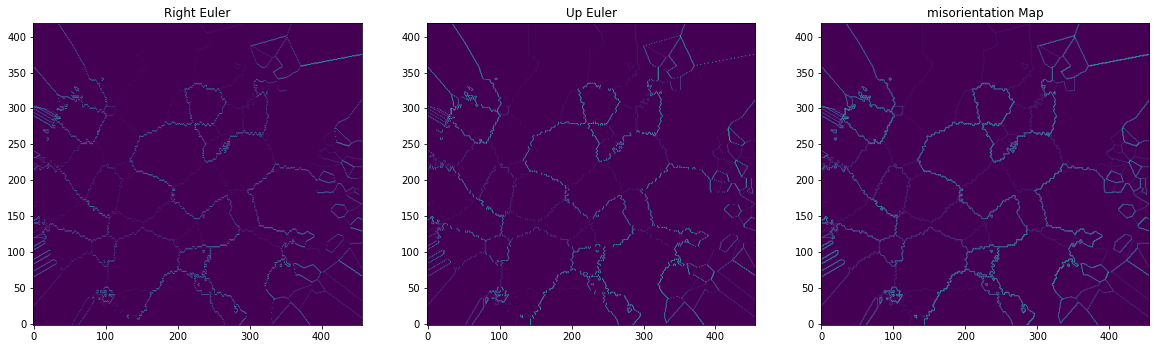

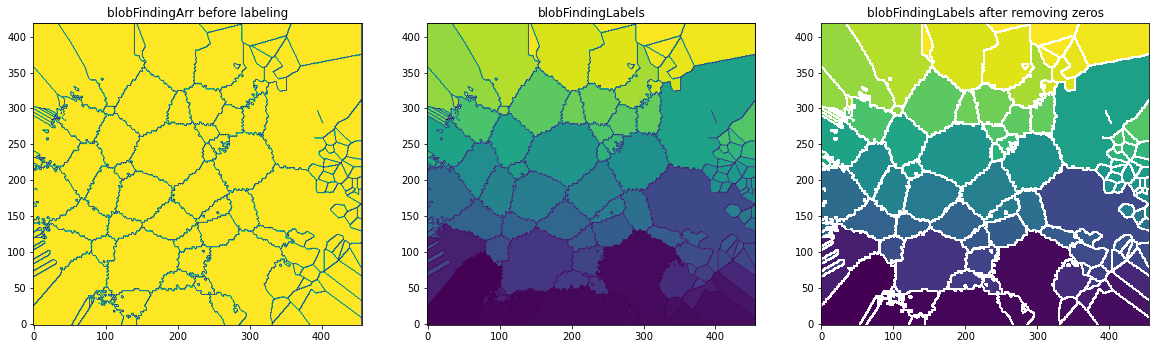

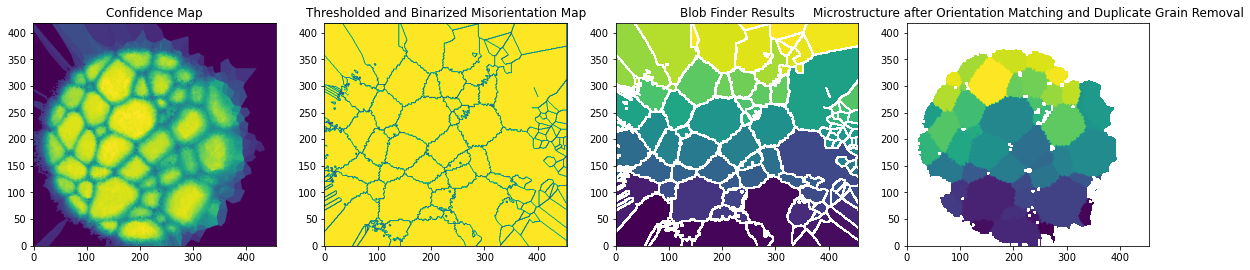

Number of Grains Found: 53


In [2]:
#######################################################################################
# set misorientation threshold (degrees) to binarize the image for blob finding
blobFindingConf = 1
# set confidence threshold for finding all voxels in a grain through orientation matching
oriMatchingConf = 0.4
#########################################################################################
Cfg = Config('Config_Files/Config_template.yml')
numGrains = find_grains(Cfg, blobFindingConf, oriMatchingConf)


# If you trust your detector parameters, stop here


## Choose small grain for optimization

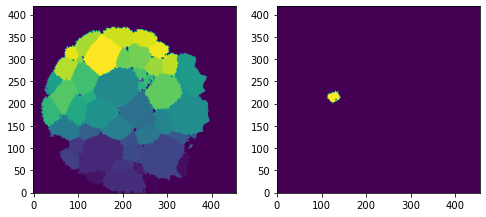

In [6]:
######################################################
grainID = 33
#######################################################
microstructure = np.array(h5py.File(Cfg.micFile, 'r')['GrainID'])

calibGrain = np.where(microstructure == grainID, 1, 0)
mic = microstructure.copy()
mic[mic != 0] += 3
fig, ax = plt.subplots(ncols=2, figsize=(8, 5))
ax[0].imshow(microstructure, origin='lower')
ax[1].imshow(calibGrain, origin='lower')
plt.show()

grain = Config(f'Config_Files/Grain_Files/Grain_%03d.yml' % grainID)


## Find the center of mass of each Bragg peak

In [7]:
path = 'Calibration_Files/'
centers_of_mass = data_prep(Cfg, grain, path)


## Run calibration

In [12]:
######################################################################################
# choose pixel distances above which peaks will be excluded from the calibration
cutoff = [30, 10]
###########################################################################################


x, oldPs, newPs, absCOM, goodidx = optimize_detector(
    centers_of_mass, Cfg, grain, cutoff)
dist0 = np.absolute(np.linalg.norm(oldPs-absCOM, axis=1)).mean()
dist1 = np.absolute(np.linalg.norm(newPs-absCOM, axis=1)).mean()
print('average pixel distance between simulated and experimental peaks before optimization:', dist0)
print('average pixel distance between simulated and experimental peaks after optimization:', dist1)
print('number of peaks used:', len(oldPs))


24.557633680503727
-0.013995894935821625
-3.1699914483433003
average pixel distance between simulated and experimental peaks before optimization: 4.330837272417509
average pixel distance between simulated and experimental peaks after optimization: 1.020948591001466
number of peaks used: 86


## Check the position of simulated Bragg peaks after calibration

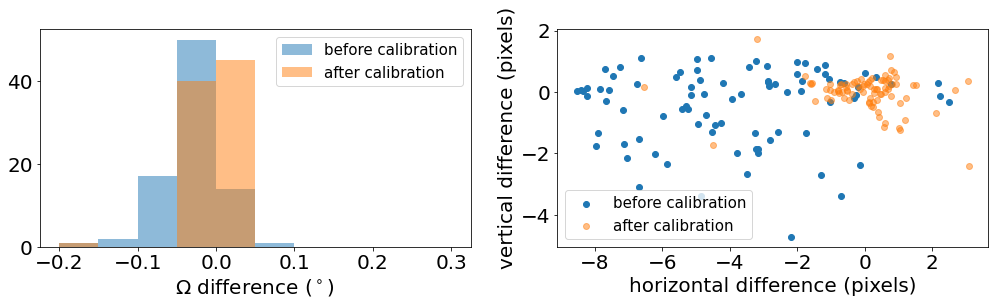

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(17, 4))
ax[0].hist(oldPs[:, 2]-absCOM[:, 2], label='before calibration',
           bins=np.arange(-0.2, 0.35, 0.05), alpha=0.5)
ax[0].hist(newPs[:, 2]-absCOM[:, 2], label='after calibration',
           bins=np.arange(-0.2, 0.35, 0.05), alpha=0.5)
ax[0].legend(fontsize=15)
ax[0].set_xlabel(r'$\Omega$ difference $(^\circ)$', fontsize=20)
ax[1].scatter(oldPs[:, 0]-absCOM[:, 0], oldPs[:, 1] -
              absCOM[:, 1], label='before calibration')
ax[1].scatter(newPs[:, 0]-absCOM[:, 0], newPs[:, 1] -
              absCOM[:, 1], label='after calibration', alpha=0.5)
ax[1].set_xlabel('horizontal difference (pixels)', fontsize=20)
ax[1].set_ylabel('vertical difference (pixels)', fontsize=20)
ax[1].legend(fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
plt.show()


## Write new parameters to config file

In [17]:
write_config_file(x)
